In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path="/content/drive/MyDrive/selected/NIFTY BANK/ICICIBANK__EQ__NSE__NSE__MINUTE.csv"

df=pd.read_csv(path)
df.head()

,timestamp,open,high,low,close,volume
0,2017-01-02 09:15:00+05:30,232.95,233.00,231.59,231.73,111910.0
1,2017-01-02 09:16:00+05:30,231.68,231.91,231.55,231.91,48472.0
2,2017-01-02 09:17:00+05:30,232.09,232.09,231.36,231.55,22959.0
3,2017-01-02 09:18:00+05:30,231.55,231.55,230.86,231.18,41806.0
4,2017-01-02 09:19:00+05:30,231.32,231.41,230.95,231.23,49992.0


In [4]:
df['date']=pd.to_datetime(df['timestamp'])
df.set_index('date',inplace=True)

In [5]:
df.isnull().sum()

timestamp      0
open         141
high         141
low          141
close        141
volume       141
dtype: int64

In [6]:
df=df.dropna(how='any')

In [7]:
df.isnull().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

### Ploting Close Price History using matplotlib

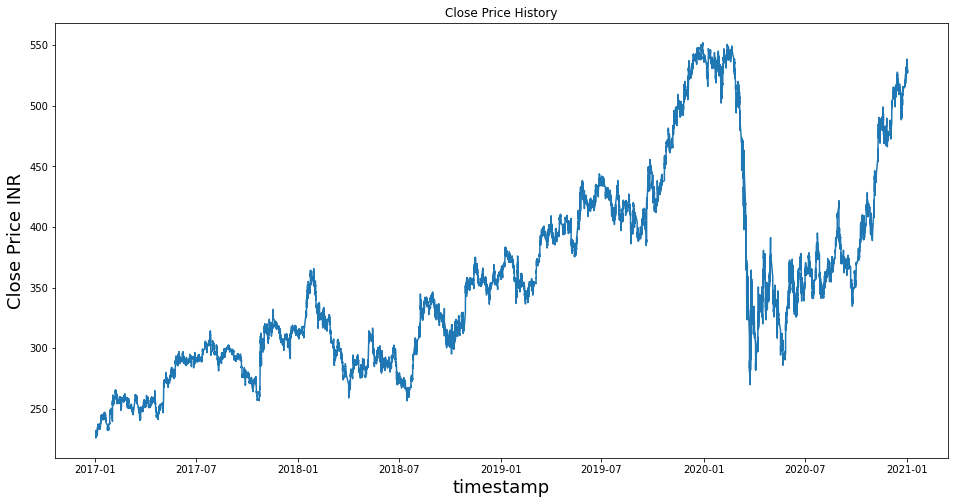

In [8]:
import seaborn as sns
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['close'])
#ax=sns.lineplot(data=df, x='timestamp',y='close', color="blue");
plt.xlabel('timestamp',fontsize=18)
plt.ylabel('Close Price INR',fontsize=18)
plt.show()

### Converting data to a numpy array

In [9]:
data = df.filter(['close'])
dataset = data.values
training_data_len = math.ceil( len(dataset) *.8) 

### Transforming the dataset array to range between 0 and 1

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [11]:
train_data = scaled_data[0:training_data_len  , : ]
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

### Spliting data for training and testing

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

### Building a LSTM Model for Stock Market Prediction

In [14]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

### Using adam optimizer and mean_squared_error as the loss function

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
model.fit(x_train, y_train, batch_size=64, epochs=1)

4630/4630 [==============================] - 318s 68ms/step - loss: 1.8898e-04


In [17]:
test_data = scaled_data[training_data_len - 60: , : ]#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [18]:
x_test = np.array(x_test)

In [19]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [20]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

### Finding the root mean squared error

In [21]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1.5181960109891917

### Plotting the predicted values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


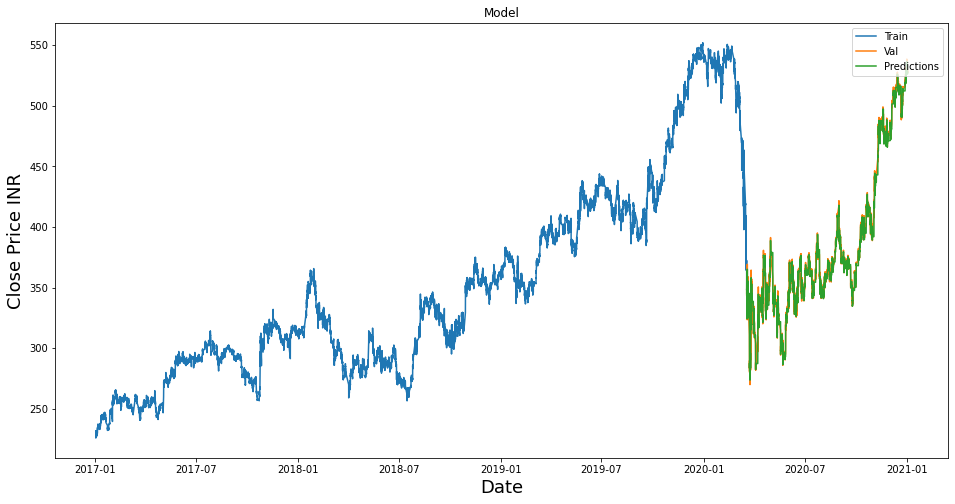

In [22]:
train = data[:training_data_len]
display = data[training_data_len:]
display['Predictions'] = predictions#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.plot(train['close'])
plt.plot(display['close'])
plt.plot(display['Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()